In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rtde_control, rtde_receive

ROBOT_HOST = "10.42.0.162" # IP address of the robot

rtde_r = rtde_receive.RTDEReceiveInterface(ROBOT_HOST)
rtde_c = rtde_control.RTDEControlInterface(ROBOT_HOST)


In [3]:
import time
from tools.helpers import MeasuringInterface
measuring_interface = MeasuringInterface(rtde_r)

In [4]:
from tools.controller import *
controller = CalibrationController(rtde_r, rtde_c)

start_point = rtde_r.getActualTCPPose()

In [5]:
# These are the poses that the robot should go to in order to "touch" the object.
# In a further cell, we can calibrate the tool width out before making a grid

# Top point
controller.move_absolute(start_point[0:3])
top_point_z = controller.find_contact_point([0, 0, -1])[2] 
controller.move_absolute(start_point[0:3])

depth = start_point[2] - top_point_z + 0.002

# Double X points
controller.move_relative([0.02, 0.003, 0])
controller.move_relative([0.0, 0, -depth], 0.01)
x_pose_1 = controller.find_contact_point([-1, 0, 0])[0:2]
controller.move_relative([0.005, 0, 0])

controller.move_relative([0, -0.003 * 2, 0])
x_pose_2 = controller.find_contact_point([-1, 0, 0])[0:2]
controller.move_relative([0.01, 0, depth])
controller.move_absolute(start_point[0:3])

# Extra x point other side
controller.move_absolute(start_point[0:3])
controller.move_relative([-0.02, 0.003, 0])
controller.move_relative([0.0, 0, -depth], 0.01)
x_pose_3 = controller.find_contact_point([1, 0, 0])[0:2]
controller.move_relative([-0.005, 0, 0])
controller.move_absolute(start_point[0:3])


# Single Y point
controller.move_relative([0, 0.02, 0])
controller.move_relative([0.0, 0, -depth], 0.01)
y_pose_1 = controller.find_contact_point([0, -1, 0])[0:2]
controller.move_relative([0, 0.01, depth])
controller.move_absolute(start_point[0:3])

# Extra single Y point
controller.move_relative([0, -0.02, 0])
controller.move_relative([0.0, 0, -depth], 0.01)
y_pose_2 = controller.find_contact_point([0, 1, 0])[0:2]
controller.move_relative([0, -0.01, depth])
controller.move_absolute(start_point[0:3])

poses = np.array([x_pose_1, x_pose_2, x_pose_3, y_pose_1, y_pose_2])

Widht x: 0.013126759966742339, width y: 0.013050843139463923


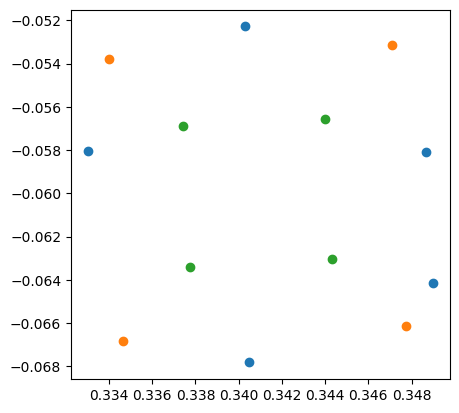

In [6]:
from tools.helpers import *
import matplotlib.pyplot as plt

tool_width = 0.0025 / 2 # We want radius

width_x = np.linalg.norm(np.array(x_pose_1) - np.array(x_pose_3)) - 2 * tool_width
width_y = np.linalg.norm(np.array(y_pose_1) - np.array(y_pose_2)) - 2 * tool_width

print(f"Widht x: {width_x}, width y: {width_y}")

corners, deltas = get_square_corners(x_pose_1, x_pose_2, y_pose_1, width_x, width_y, tool_width)

plt.scatter(poses[:, 0], poses[:, 1])
plt.scatter(corners[:, 0], corners[:, 1])

grid = calculate_grid_on_square(corners, 2)

plt.scatter(grid[:, :, 0], grid[:, :, 1])
plt.gca().set_aspect('equal')

# Also save results to numpy file
np.save("calibration_data.npy", {
    "corners": corners,
    "poses": poses,
    "top_point_z": top_point_z,
})

In [7]:
print([row for row in grid])
print([row for row in grid.transpose((1,0,2))])

[array([[ 0.3439858 , -0.05654299],
       [ 0.33743085, -0.05687371]]), array([[ 0.34431843, -0.06306003],
       [ 0.33776349, -0.06339075]])]
[array([[ 0.3439858 , -0.05654299],
       [ 0.34431843, -0.06306003]]), array([[ 0.33743085, -0.05687371],
       [ 0.33776349, -0.06339075]])]


In [8]:

rtde_c.zeroFtSensor()

name = "2x2_grid_normal"
measuring_interface.start_measuring(name)

time.sleep(3)

grid = calculate_grid_on_square(corners, 2)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
task_frame = [0, 0, 0, 0, 0, 0]
selection_vector = [0, 0, 1, 0, 0, 0]
wrench = [0, 0, -5, 0, 0, 0]
force_type = 2
limits = [0.1, 0.1, 0.01, 0.1, 0.1, 0.1]

normal_forces = -1 * np.arange(0, 10, 1)

controller.move_absolute(start_point[0:3])

for row in grid:
    for point in row:
        
        # Move above point
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
        controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
        
        # Now apply normal forces
        for force in normal_forces:
            wrench[2] = force
            rtde_c.forceMode(task_frame, selection_vector, wrench, force_type, limits)
            time.sleep(0.5)
            
        controller.move_absolute([point[0], point[1], top_point_z + z_clearance], velocity=0.01)
        

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

In [13]:
# XY measurements (by slipping the probe)

rtde_c.zeroFtSensor()

name = "2x2_grid_xy"
measuring_interface.start_measuring(name)

time.sleep(3)

grid = calculate_grid_on_square(corners, 2)

# Now push on every point in the grid to calibrate
z_clearance = 0.005
task_frame = [0, 0, 0, 0, 0, 0]
selection_vector = [0, 0, 1, 0, 0, 0]
wrench = [0, 0, -5, 0, 0, 0]
force_type = 2
limits = [0.1, 0.1, 0.01, 0.1, 0.1, 0.1]

# (normal force, side force)
forces = np.array([[1, 1], [1, 2], [1, 5], [1, 10], 
                           [2, 2], [2, 5], [2, 10],
                                   [5, 5], [5, 10],
                                           [10, 10]
                ])

controller.move_absolute(start_point[0:3])

for force in forces:
    
    normal_force, side_force = force
                    
    for reversed in [False, True]:

        selection_vector = [1, 0, 1, 0, 0, 0]
        limits = [0.005, 0.1, 0.01, 0.1, 0.1, 0.1]
        wrench = [abs(side_force) if reversed else -abs(side_force), 0, -normal_force, 0, 0, 0] 
        for row in grid:
            
            # Start from first point in grid (which is always most +x)
            point = row[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            # Apply force until meeting next point
            next_point = row[0 if reversed else -1]
            rtde_c.forceMode(task_frame, selection_vector, wrench, force_type, limits)
            
            # Move to last point in row
            distance = 9999
            while distance > 0.001:
                distance = np.linalg.norm(np.array(rtde_r.getActualTCPPose()[0:2]) - np.array(next_point))
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)
            
        # Do the same with columns
        selection_vector = [0, 1, 1, 0, 0, 0]
        limits = [0.1, 0.005, 0.01, 0.1, 0.1, 0.1]
        wrench = [0, abs(side_force) if reversed else -abs(side_force), -normal_force, 0, 0, 0] 
        for col in grid.transpose((1,0,2)):
            
            # Start from first point in grid (which is always most +x)
            point = col[-1 if reversed else 0]
            
            # Move to start point
            controller.move_absolute([point[0], point[1], top_point_z + z_clearance])
            controller.move_absolute([point[0], point[1], top_point_z], velocity=0.01)
            
            # Apply force
            next_point = col[0 if reversed else -1]
            rtde_c.forceMode(task_frame, selection_vector, wrench, force_type, limits)
            
            # Move to last point in column
            distance = 9999
            while distance > 0.001:
                distance = np.linalg.norm(np.array(rtde_r.getActualTCPPose()[0:2]) - np.array(next_point))
            
            # Move back to safety        
            controller.move_relative([0, 0, z_clearance], velocity=0.01)

rtde_c.forceModeStop()
controller.move_absolute(start_point[0:3])

time.sleep(3)
measuring_interface.stop_measuring()

KeyboardInterrupt: 

In [14]:
measuring_interface.stop_measuring()
controller.move_absolute(start_point[0:3])

[0.3404030246422786, -0.06116461233719473, -0.14457471884326506]

In [11]:
rtde_c.stopScript()

In [12]:
controller.move_absolute(start_point[0:3])

[0.3403715188009066, -0.06109771305103859, -0.14460998593157465]